# Dimensionality Reduction 

##### Author: Saurabh Kumar


##### Agenda
- PCA
- SVD
- Latent semantic indexing (LSI/LSA)
- Latent dirichlet allocation (LDA)

In [1]:
# INSTALLATION:

!pip install pyldavis

  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97716 sha256=d16aa22592d0d6d71f3e63fb429120b337868b03ec2eab0dfcdc9241885aa88b
  Stored in directory: C:\Users\saurabhkumar9\AppData\Local\pip\Cache\wheels\98\71\24\513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32047 sha256=8963fb7d123bcd5cb6a1c36907a5af131ed7e31be6dcceaef89fd42ae2294922
  Stored in directory: C:\Users\saurabhkumar9\AppData\Local\pip\Cache\wheels\20\5a\d8\1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
from collections import defaultdict, Counter
from configparser import ConfigParser, ExtendedInterpolation
from IPython.core.display import display, HTML
from IPython.display import Image
from IPython.lib.display import YouTubeVideo
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import DiffMetric
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyLDAvis  # conda install pyldavis
import pyLDAvis.gensim
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import spacy
from spacy.matcher import Matcher, PhraseMatcher
from spacy.lang.en.stop_words import STOP_WORDS

%matplotlib inline

C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\thinc\neural\train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\thinc\check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
C:\Users\saurabhkumar9\AppData\Local\Continuum\anaconda2\envs\spyder\lib\site-packages\thinc\check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


#Linear algebra: 
https://docs.scipy.org/doc/numpy/reference/routines.linalg.html

In [2]:
# Dot product
import numpy as np
from numpy import linalg as LA
from numpy.linalg import inv

a = [[1, 0], [0, 1]]
b = [[4, 1], [2, 2]]
print(np.dot(a, b))
print(np.dot(b, a))
print()

c = np.array([[3, -2], [-1, 3]])
print(c)
print(LA.eigvals(c))
print(c.transpose())
print(inv(c))

[[4 1]
 [2 2]]
[[4 1]
 [2 2]]

[[ 3 -2]
 [-1  3]]
[4.41421356 1.58578644]
[[ 3 -1]
 [-2  3]]
[[0.42857143 0.28571429]
 [0.14285714 0.42857143]]


##### Limitations of the vector space model:

We generally do not want to feed a large number of features directly into a machine learning algorithm because:
- They are expensive to store.
- They slow down computations (e.g. in algorithms like k nearest neighbors)
- Large samples are required to avoid overfitting.


**Synonymy:** the characteristic of language to have several terms that mean essentially the same thing
-  In the SAS technical support data set the terms “frozen” and “hangs” often refer to the same situation where the program has reached a point where nothing is happening and yet the user cannot continue working

**Polysemy:** is the tendency for the same term to mean different things in different contexts.
- The term “monitor” in technical support data is a good example of this. At times it refers to the computer screen, sometimes it refers to a piece of software that displays a graphical result and still other times it refers to the user “watching” or “observing” an event

**Term dependence:** refers to the tendency for certain terms to be highly correlated with one another. This problem is not unique to text but also occurs with most other sets of data as well. 
- The terms “error” and “message” are strongly correlated in the technical support collection. When one occurs, the other also tends to occur. A pair of documents, each containing these two terms, may have their similarity overrated in this case

SOURCE: 
- https://davidrosenberg.github.io/ml2015/docs/13.Lab.PCA-SVD-LDA.pdf
- ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

## Dimensionality Reduction and Semantic Transformations

### Principal Component Analysis (PCA)

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.

- Principal Component Analysis (PCA) is a dimension-reduction tool that can be used to reduce a large set of variables to a small set that still contains most of the information in the large set.
- Principal component analysis (PCA) is a mathematical procedure that transforms a number of (possibly) correlated variables into a (smaller) number of uncorrelated variables called principal components. 
- PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance
- The first principal component accounts for as much of the variability in the data as possible, and each succeeding component accounts for as much of the remaining variability as possible.

SOURCE: 
- http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
- ftp://statgen.ncsu.edu/pub/thorne/molevoclass/AtchleyOct19.pdf

In [3]:
# PCA
# SOURCE: https://intoli.com/blog/pca-and-svd/
# Image("https://s3.amazonaws.com/nlp.practicum/pca.png", width=700)

![](https://s3.amazonaws.com/nlp.practicum/pca.png)

In [3]:
# create an example dataframe
X_df = pd.DataFrame([[-1, 1], [-2, 1], [-3, 2], [1, -1], [2, -1], [3, -2]])
X_df

,0,1
0,-1,1
1,-2,1
2,-3,2
3,1,-1
4,2,-1
5,3,-2


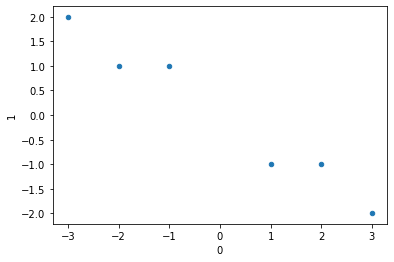

In [4]:
# plot the data
X_df.plot.scatter(x=0, y=1)

In [5]:
# import PCA
from sklearn.decomposition import PCA

# run PCA to create 2 principal components
pca = PCA(n_components=2)
fit_pca = pca.fit_transform(X_df)

# create the transformed matrix
pca_df = pd.DataFrame(fit_pca, columns=['component 1','component 2'])
pca_df

,component 1,component 2
0,1.383406,0.293579
1,2.221898,-0.251335
2,3.605304,0.042244
3,-1.383406,-0.293579
4,-2.221898,0.251335
5,-3.605304,-0.042244


(-2, 2)

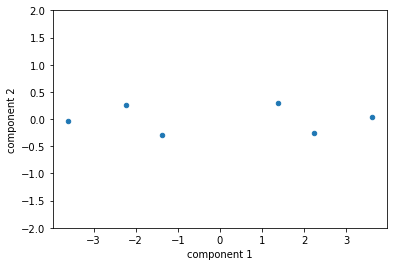

In [6]:
# plot the prinipal components
pca_df.plot.scatter(x='component 1', y='component 2')

# increase range of y-axis to match the original visualization
plt.ylim(-2,2)

On further PCA the result is same as data is already orthogonal and there is no correlation b/w them.

In [7]:
fit2 = pca.fit_transform(pca_df)
df2 = pd.DataFrame(fit2, columns=['component 3','component 4'])
df2

,component 3,component 4
0,1.383406,0.293579
1,2.221898,-0.251335
2,3.605304,0.042244
3,-1.383406,-0.293579
4,-2.221898,0.251335
5,-3.605304,-0.042244


The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the “core” of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

In [8]:
print('Singular values: {}'.format(pca.singular_values_.round(2))) 

# Singular Values are the l2 norm of each component
# e.g. np.sqrt(sum([i**2 for i in pca_df['component 1']]))
print('Singluar Value 1: {}'.format(np.linalg.norm(pca_df['component 1'], ord=2).round(2)))
print('Singluar Value 2: {}'.format(np.linalg.norm(pca_df['component 2'], ord=2).round(2)))

print('\nExplained variance ratio: {}'.format(pca.explained_variance_ratio_))

Singular values: [6.3  0.55]
Singluar Value 1: 6.3
Singluar Value 2: 0.55

Explained variance ratio: [0.99244289 0.00755711]


In [24]:
np.linalg.norm(X_df[0])

5.291502622129181

##### Manually create the first singular value

In [9]:
# view the first prinicipal component
pca_df['component 1']

0    1.383406
1    2.221898
2    3.605304
3   -1.383406
4   -2.221898
5   -3.605304
Name: component 1, dtype: float64

In [10]:
# square all values
pca_df['component 1'] ** 2

0     1.913812
1     4.936831
2    12.998215
3     1.913812
4     4.936831
5    12.998215
Name: component 1, dtype: float64

In [11]:
# take the sum of squares
sum(pca_df['component 1'] ** 2)

39.697715603592215

In [12]:
# take the sqaure root of the sum of squares
np.sqrt(sum(pca_df['component 1'] ** 2))

6.300612319734664

In [13]:
print('Components:\n {}'.format(pca.components_.round(2)))

Components:
 [[-0.84  0.54]
 [ 0.54  0.84]]


##### Recreate PCA through SVD

In [41]:
# recreate PCA using SVD (we will explain this calculation in the next section)
u,s,vt = np.linalg.svd(X_df, full_matrices=False)

print("singular values =\n {} \n".format(np.round(s, 2)))
print("components =\n {} \n".format(np.round(vt, 2)))

# pca
pd.DataFrame(u*s)

singular values =
 [6.3  0.55] 

components =
 [[ 0.84 -0.54]
 [ 0.54  0.84]] 



,0,1
0,-1.383406,0.293579
1,-2.221898,-0.251335
2,-3.605304,0.042244
3,1.383406,-0.293579
4,2.221898,0.251335
5,3.605304,-0.042244


### Singular Value Decomposition

In linear algebra, the singular-value decomposition (SVD) is a factorization of a real or complex matrix.

Let A be an m × n term-document frequency matrix with rank r, r ≤ n. Without loss of generality let m ≥ n hold so that there are more terms than documents. The singular value decomposition of A can be stated succinctly as A = U*Σ*VT,

- U is an m × r orthogonal matrix whose columns make up the left singular vectors
- Σ is an r × r dimensional diagonal matrix whose diagonal elements are termed singular values
- V is an r × n orthogonal matrix whose columns form the right singular vectors of A.

In [15]:
# SVD
# Image("https://s3.amazonaws.com/nlp.practicum/svd_graph.png", width=400, height=200)

![](https://s3.amazonaws.com/nlp.practicum/svd_graph.png)

In [16]:
# SVD
# Image("https://s3.amazonaws.com/nlp.practicum/svd3.png", width=400)

### Reduced SVD

The SVD comes in two forms, a full SVD, and a reduced SVD. In NLP, we tend to focus on the reduced SVD, using SVD for dimensionality reduction.

SVD can be viewed as a sum of rank one matrices.The matrix A can then be approximated by choosing any k ≤ r. This generates a rank k matrix, Ak, that is the best rank-k approximation to A in terms of least-squares best fit

SOURCE: ftp://ftp.sas.com/techsup/download/EMiner/TamingTextwiththeSVD.pdf

"Singlular Value Decomposition (SVD) allows us to reduce the dimensionality of a matrix. Instead of analyzing a full document-term matrix with all documents and all terms, we can reduce the matrix into a lower rank representation. In this, we combine the meaning of terms by compressing the number of columns.

To reduce the size of our matrix without losing much quality, we can perform a low-rank approximation on matrix C. This is done by keeping the top k values of Σ and setting the rest to zero, where k is the new rank. Since Σ contains eigenvalues in descending order, and the effect of small eigenvalues on matrix products is small, the zeroing of the lowest values will leave the reduced matrix C' approximate to C. How to retrieve the most optimal k is not an easy task, since we want k top large enough to include as much variety as possible from our original matrix C, but small enough to exclude sampling errors and redundancy. To do this in a formal way, the Frobenius norm can be applied to measure the discrepancy between C and C_k. A less extensive way is just to try out a couple of different k-values and see what generates the best results."

SOURCE: https://simonpaarlberg.com/post/latent-semantic-analyses/

In [17]:
# reduced SVD
# Image("https://s3.amazonaws.com/nlp.practicum/reduced_svd.png", width=500, height=500)

![](https://s3.amazonaws.com/nlp.practicum/reduced_svd.png)

In [18]:
# SVD
# Image("https://s3.amazonaws.com/nlp.practicum/svd2.png", width=700)

1. ![](https://s3.amazonaws.com/nlp.practicum/svd2.png)

In [19]:
# Truncated SVD
# SOURCE: https://www.researchgate.net/figure/Singular-value-decomposition-SVD-and-a-truncated-SVD-matrix_fig1_227060873
# Image("https://s3.amazonaws.com/nlp.practicum/truncated_svd.png", width=500)

1. ![](https://s3.amazonaws.com/nlp.practicum/truncated_svd.png)

In [2]:
# SVD
#Image("https://s3.amazonaws.com/nlp.practicum/svd4.png", width=700)

1. ![](https://s3.amazonaws.com/nlp.practicum/svd4.png)

##### SVD approximation equation
Equation 1 implies that one can get a rough approximation to A by taking the product of the first singular value with the matrix formed from the outer product of the first column of U with the first column of V . The matrix formed, A1, will be m × n but will be of only rank one. Of all possible matrices, B, of rank one, ||A − B||2 will be smallest when B = A1 holds. One can improve the approximation by forming the product of the second singular value with the outer product of the second columns of U and V , and then adding this result to A1. The resultant matrix, A2, will be the the best rank-two approximation to A. The approximations can be successively improved by repeating the process until k = r holds and the original matrix is produced.

In [4]:
# reduced SVD equation
#Image("https://s3.amazonaws.com/nlp.practicum/svd_truncated_equation.png", width=500, height=200)

1. ![](https://s3.amazonaws.com/nlp.practicum/svd_truncated_equation.png)

##### Coursera Course on SVD

SOURCE: https://www.coursera.org/learn/matrix-factorization/lecture/K5NBy/singular-value-decomposition

##### When is the SVD Technique Appropriate?
For most Text Mining problems, the SVD will be entirely appropriate to use. Without a data reduction technique, there will be more variables (terms) available than one can use in a data mining model. Some method must be applied to select an appropriate set from which a text mining solution can be built. Unlike term elimination, the SVD technique allows one to derive significantly fewer variables from the original variables. There are some drawbacks to using the SVD, however. Computationally, the SVD is fairly resource intensive and requires a large amount of RAM. The user must have access to these resources in order for the decomposition to be obtained.

##### How Many Dimensions Should be Used?
The choice for the number of dimensions k to use can be a crucial aspect of many text mining solutions. With too few dimensions, the model will fail to explain prominent relationships in the text. On the other hand, using too many dimensions will add unnecessary noise to the model and make training an effective model nearly impossible. In practice, there is an upper bound of at most a few hundred dimensions from which to build a model. So the user should not need to consider more than this

### SVD in comparision to PCA
Using the below image displaying several documents that contain only two terms (A&B)

**SVD:** draw a line through the points in such a way that the sum of the distances from each point to the line is minimized. The documents can then be perpendicularly projected onto this new line. The circles indicate the locations of the projected documents. This line and the new locations for the documents, can be obtained by using the SVD

**PCA:** Spread the points out as much as possible on this new line to maximize the variance of the points that are projected onto the line. This line is formed by performing Principal Component Analysis

Although based on equivalent procedures, since PCA and TM’s SVD approach operate on different data, they do not produce the same results. Depending on whether the raw data is used or the covariance matrix is used, different vectors will be found as basis vectors for the reduced space

While the PCA component maximizes the variance, the SVD finds the best fitting line in the least-squares sense. Depending on the nature of the data, these two lines may or may not be fairly close to one another. 

In [5]:
# SVD vs PCA
#Image("https://s3.amazonaws.com/nlp.practicum/svd_vs_pca.png", width=1000)

1. ![](https://s3.amazonaws.com/nlp.practicum/svd_vs_pca.png)

In [23]:
# SVD vs PCA
# Image("https://s3.amazonaws.com/nlp.practicum/svd_vs_pca2.png", width=700)

1. ![](https://s3.amazonaws.com/nlp.practicum/svd_vs_pca2.png)

### SVD Example

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

In [45]:
# GENSIM_DICTIONARY_PATH = r'gensim_dictionary_path.txt' 
# GENSIM_CORPUS_PATH = r'gensim_corpus_path.txt'

# CLEANED_TEXT_PATH = r'https://raw.githubusercontent.com/Alexjmsherman/nlp_practicum_cohort3_student/master/raw_data/cleaned_text/cleaned_text.txt?token=ABXRUPVMSIR3QOBGSWUI5SS5CA6AY'
CLEANED_PATH = r"C:\Users\saurabhkumar9\NLP Practicum Materials\text1.txt"
texts = pd.read_csv(CLEANED_PATH, sep='\t',header=None)
texts = [line[0].split() for line in texts.values]
print(texts[0])

['immune_complexes', 'in', 'rheumatic', 'disease']


In [47]:
# combine tokens from the first few lists into sentences
svd_data = [' '.join(text) for text in texts[0:8]]

# create a document term matrix of the token counts
vect = CountVectorizer(max_features=10, stop_words='english')
dtm = vect.fit_transform(svd_data)

# create a dataframe
vocab = vect.get_feature_names()
df = pd.DataFrame(dtm.toarray(), columns=vocab)
df

,disease,evidence,including,increased,intent,latency,lymphocytes,manifestations,nervousness,patients
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,1,1,0
4,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,1
6,1,0,0,0,0,1,0,0,0,0
7,1,1,0,0,1,0,0,0,0,1


In [52]:
# decompose the matrix using SVD
U, s, VT = np.linalg.svd(df, full_matrices=False)
S = np.diag(s) # converting to diagonal matrix

In [28]:
# what are U, S and V
print("U =\n", np.round(U, decimals=2), "\n")
print("S =\n", np.round(S, decimals=2), "\n")
print("V^T =\n", np.round(VT, decimals=2), "\n")

U =
 [[ 0.25  0.18 -0.28 -0.    0.24 -0.32 -0.78  0.23]
 [ 0.   -0.    0.   -1.    0.    0.    0.    0.  ]
 [ 0.25  0.18 -0.28 -0.    0.24 -0.32  0.59  0.57]
 [ 0.61 -0.79 -0.03  0.    0.03  0.09 -0.   -0.  ]
 [ 0.25  0.18 -0.28 -0.    0.24 -0.32  0.2  -0.79]
 [ 0.34  0.36  0.07  0.    0.45  0.74 -0.   -0.  ]
 [ 0.28  0.24 -0.52 -0.   -0.73  0.26 -0.   -0.  ]
 [ 0.5   0.32  0.7  -0.   -0.29 -0.27 -0.   -0.  ]] 

S =
 [[3.14 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.94 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.48 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.87 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.67 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]] 

V^T =
 [[ 0.79  0.35  0.19  0.19  0.16  0.09  0.    0.19  0.19  0.27]
 [ 0.34 -0.24 -0.41 -0.41  0.16  0.13 -0.   -0.41 -0.41  0.35]
 [-0.41  0.45 -0.02 -0.02  0.47 -0.35  0.   -0.02 -0.02  0.52]
 [ 0.   -0.    0.    0.   -0.   -0. 

In [29]:
# U is othonormal
# These vectors are orthogonal to one another; form a basis for the reduced space

# each vector is normalized (unit vector)
# multiply by itself returns 1
col1 = np.array([i[0] for i in U])
print(col1, '\n')
print('vector 1: {}'.format(round(col1.dot(col1), 2), '\n'))

col2 = np.array([i[1] for i in U])
print('vector 2: {}'.format(round(col2.dot(col2), 2)))

# and each vector is orthogonal to the other vectors
# multiply different vectors returns 0
print('dot product: {}'.format(round(col1.dot(col2), 2)))

[2.50826823e-01 1.11022302e-16 2.50826823e-01 6.10650714e-01
 2.50826823e-01 3.35259936e-01 2.79106243e-01 4.98060138e-01] 

vector 1: 1.0
vector 2: 1.0
dot product: 0.0


In [30]:
# rebuild the original matrix from U,S, and V^T
A2 = np.dot(U, np.dot(S, VT))
print("A2 =\n", A2.round(2))

A2 =
 [[ 1. -0.  0. -0. -0.  0.  0. -0. -0. -0.]
 [-0.  0.  0.  0.  0. -0.  1.  0.  0.  0.]
 [ 1. -0. -0.  0. -0.  0.  0. -0. -0.  0.]
 [ 1.  1.  1.  1.  0. -0.  0.  1.  1. -0.]
 [ 1. -0. -0.  0. -0.  0.  0.  0.  0. -0.]
 [ 1. -0. -0.  0. -0. -0.  0.  0.  0.  1.]
 [ 1. -0.  0. -0.  0.  1.  0. -0. -0. -0.]
 [ 1.  1.  0. -0.  1. -0.  0. -0. -0.  1.]]


In [31]:
# example of np.zero_like
np.zeros_like(S)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [32]:
# S_reduced is the same as S but with only the top n elements kept
S_reduced = np.zeros_like(S)

# only keep top few eigenvalues
eigen_num = 3
S_reduced[:eigen_num, :eigen_num] = S[:eigen_num,:eigen_num]

# show S_rediced which has less info than original S
print("S_reduced =\n", S_reduced.round(2))

S_reduced =
 [[3.14 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.94 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.48 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [33]:
# reduce VT by S_reduced
S_reduced_VT = np.dot(S_reduced, VT)
print("S_reduced_VT = \n", S_reduced_VT.round(2))

S_reduced_VT = 
 [[ 2.48  1.11  0.61  0.61  0.5   0.28  0.    0.61  0.61  0.83]
 [ 0.67 -0.47 -0.79 -0.79  0.32  0.24 -0.   -0.79 -0.79  0.68]
 [-0.61  0.67 -0.03 -0.03  0.7  -0.52  0.   -0.03 -0.03  0.78]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [34]:
# each Singular Value vector is a linear combination of original words
U_S_reduced = np.dot(U, S_reduced)
df = pd.DataFrame(U_S_reduced.round(2))

# show colour coded so it is easier to see significant word contributions to a topic
df.style.background_gradient(cmap=plt.get_cmap('Blues'))

,0,1,2,3,4,5,6,7
0,0.79,0.34,-0.41,0,0,0,0,0
1,0,-0,0,0,0,0,0,0
2,0.79,0.34,-0.41,0,0,0,0,0
3,1.92,-1.52,-0.05,0,0,0,0,0
4,0.79,0.34,-0.41,0,0,0,0,0
5,1.05,0.69,0.11,0,0,0,0,0
6,0.88,0.47,-0.76,0,0,0,0,0
7,1.56,0.62,1.04,0,0,0,0,0


In [35]:
# recreate using sklearn (explained below)
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=3)
tsvd.fit_transform(df).round(2)

array([[ 0.79, -0.34, -0.41],
       [ 0.  , -0.  ,  0.  ],
       [ 0.79, -0.34, -0.41],
       [ 1.92,  1.52, -0.03],
       [ 0.79, -0.34, -0.41],
       [ 1.05, -0.69,  0.1 ],
       [ 0.88, -0.46, -0.77],
       [ 1.56, -0.64,  1.03]])

### Latent Semantic Indexing (LSI)
Latent semantic indexing (LSI) is an indexing and retrieval method that uses a mathematical technique called singular value decomposition (SVD) to identify patterns in the relationships between the terms and concepts contained in an unstructured collection of text. LSI is based on the principle that words that are used in the same contexts tend to have similar meanings. A key feature of LSI is its ability to extract the conceptual content of a body of text by establishing associations between those terms that occur in similar contexts.

The method, also called latent semantic analysis (LSA), uncovers the underlying latent semantic structure in the usage of words in a body of text and how it can be used to extract the meaning of the text in response to user queries, commonly referred to as concept searches. Queries, or concept searches, against a set of documents that have undergone LSI will return results that are conceptually similar in meaning to the search criteria even if the results don’t share a specific word or words with the search criteria.

##### Overview
LSA can use a term-document matrix which describes the occurrences of terms in documents; it is a sparse matrix whose rows correspond to terms and whose columns correspond to documents. A typical example of the weighting of the elements of the matrix is tf-idf (term frequency–inverse document frequency): the weight of an element of the matrix is proportional to the number of times the terms appear in each document, where rare terms are upweighted to reflect their relative importance.

This matrix is also common to standard semantic models, though it is not necessarily explicitly expressed as a matrix, since the mathematical properties of matrices are not always used.

##### Rank Lowering
After the construction of the occurrence matrix, LSA finds a low-rank approximation to the term-document matrix. There could be various reasons for these approximations:

**The original term-document matrix is presumed too large for the computing resources:** in this case, the approximated low rank matrix is interpreted as an approximation (a "least and necessary evil").
**The original term-document matrix is presumed noisy:** for example, anecdotal instances of terms are to be eliminated. From this point of view, the approximated matrix is interpreted as a de-noisified matrix (a better matrix than the original).
The original term-document matrix is presumed overly sparse relative to the "true" term-document matrix. That is, the original matrix lists only the words actually in each document, whereas we might be interested in all words related to each document—generally a much larger set due to synonymy.
The consequence of the rank lowering is that some dimensions are combined and depend on more than one term:

{(car), (truck), (flower)} --> {(1.3452 * car + 0.2828 * truck), (flower)}

This mitigates the problem of identifying synonymy, as the rank lowering is expected to merge the dimensions associated with terms that have similar meanings. It also mitigates the problem with polysemy, since components of polysemous words that point in the "right" direction are added to the components of words that share a similar meaning. Conversely, components that point in other directions tend to either simply cancel out, or, at worst, to be smaller than components in the directions corresponding to the intended sense.


##### Use Cases
- Compare the documents in the low-dimensional space (data clustering, document classification).
- Find similar documents across languages, after analyzing a base set of translated documents (cross language retrieval).
- Find relations between terms (synonymy and polysemy).
- Given a query of terms, translate it into the low-dimensional space, and find matching documents (information retrieval).
- Find the best similarity between small groups of terms, in a semantic way (i.e. in a context of a knowledge corpus), as for example in multi choice questions MCQ answering model.
- Expand the feature space of machine learning / text mining systems 
- Analyze word association in text corpus 

Synonymy and polysemy are fundamental problems in natural language processing:
* **Synonymy** is the phenomenon where different words describe the same idea. Thus, a query in a search engine may fail to retrieve a relevant document that does not contain the words which appeared in the query. For example, a search for "doctors" may not return a document containing the word "physicians", even though the words have the same meaning.

* **Polysemy** is the phenomenon where the same word has multiple meanings. So a search may retrieve irrelevant documents containing the desired words in the wrong meaning. For example, a botanist and a computer scientist looking for the word "tree" probably desire different sets of documents.

##### Limitations
LSA cannot capture polysemy (i.e., multiple meanings of a word) because each occurrence of a word is treated as having the same meaning due to the word being represented as a single point in space. For example, the occurrence of "chair" in a document containing "The Chair of the Board" and in a separate document containing "the chair maker" are considered the same. The behavior results in the vector representation being an average of all the word's different meanings in the corpus, which can make it difficult for comparison. However, the effect is often lessened due to words having a predominant sense throughout a corpus (i.e. not all meanings are equally likely).

SOURCE: https://en.wikipedia.org/wiki/Latent_semantic_analysis#cite_note-38

In [57]:
from sklearn.decomposition import TruncatedSVD

In [58]:
# review data
svd_data[0]

'immune_complexes in rheumatic disease'

In [59]:
# vectorize the text with TFIDF
vect = TfidfVectorizer(max_features=10)
fit_vect = vect.fit_transform(svd_data)
pd.DataFrame(fit_vect.toarray(), columns=vect.get_feature_names())

,and,disease,evidence,in,of,patients,the,they,to,with
0,0.000000,0.622455,0.000000,0.782655,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.748789,0.000000,0.000000,0.662808,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.280764,0.197655,0.000000,0.000000,0.248525,0.000000,0.640445,0.000000,0.000000,0.640445
3,0.183248,0.129004,0.242203,0.000000,0.324412,0.000000,0.627003,0.577995,0.242203,0.000000
4,0.000000,0.189713,0.000000,0.238539,0.238539,0.000000,0.922067,0.000000,0.000000,0.000000
5,0.000000,0.311413,0.000000,0.391561,0.391561,0.584670,0.000000,0.000000,0.000000,0.504523
6,0.498378,0.350852,0.000000,0.441151,0.000000,0.000000,0.000000,0.000000,0.658717,0.000000
7,0.000000,0.174667,0.327934,0.000000,0.658863,0.327934,0.000000,0.000000,0.000000,0.565960


Dimensionality reduction using TruncatedSVD (aka LSA).

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with scipy.sparse matrices efficiently.

In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).

SOURCE: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

In [60]:
# retain one component
tsvd = TruncatedSVD(n_components=1)
tsvd.fit_transform(fit_vect)

array([[0.58993214],
       [0.52773497],
       [0.77467273],
       [0.63876712],
       [0.6881118 ],
       [0.73156833],
       [0.59060424],
       [0.61090209]])

In [61]:
# retain two components
tsvd = TruncatedSVD(n_components=2)
tsvd.fit_transform(fit_vect)

array([[ 0.58993214,  0.58346403],
       [ 0.52773497,  0.67132692],
       [ 0.77467273, -0.42564204],
       [ 0.63876712, -0.34289944],
       [ 0.6881118 , -0.29925978],
       [ 0.73156833, -0.05814679],
       [ 0.59060424,  0.62931669],
       [ 0.61090209, -0.44677419]])

# LDA (Latent dirichlet allocation)

The normal distribution is a probability distribution over all the real numbers. It is described by a mean and a variance. The mean is the expected value of this distribution, and the variance tells us how much we can expect samples to deviate from the mean. If the variance is very high, then you’re going to see values that are both much smaller than the mean and much larger than the mean. If the variance is small, then the samples will be very close to the mean. If the variance goes close to zero, all samples will be almost exactly at the mean.

The dirichlet distribution is a probability distribution as well - but it is not sampling from the space of real numbers. Instead it is sampling over a probability simplex.

And what is a probability simplex? It’s a bunch of numbers that add up to 1. For example:

- (0.6, 0.4)
- (0.1, 0.1, 0.8)
- (0.05, 0.2, 0.15, 0.1, 0.3, 0.2)

These numbers represent probabilities over K distinct categories. In the above examples, K is 2, 3, and 6 respectively. That’s why they are also called categorical distributions.

When we are dealing with categorical distributions and we have some uncertainty over what that distribution is, simplest way to represent that uncertainty as a probability distribution is the Dirichlet.

SOURCE: 
- [What is an intuitive explanation of the Dirichlet distribution?](https://www.quora.com/What-is-an-intuitive-explanation-of-the-Dirichlet-distribution)
- [VIDEO: Digging into the Dirichlet Distribution](https://www.hakkalabs.co/articles/the-dirichlet-distribution)
- [Introduction to Latent Dirichlet Allocation:](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/)
- [Gensim LDA: Tips and Tricks](https://miningthedetails.com/blog/python/lda/GensimLDA/)

**Intro:**
    
**Topic Models**, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

Dimensionality Reduction, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}

Unsupervised Learning, where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight.

Tagging, abstract “topics” that occur in a collection of documents that best represents the information in them.

There are several existing algorithms you can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)

**Theoretical Overview**

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

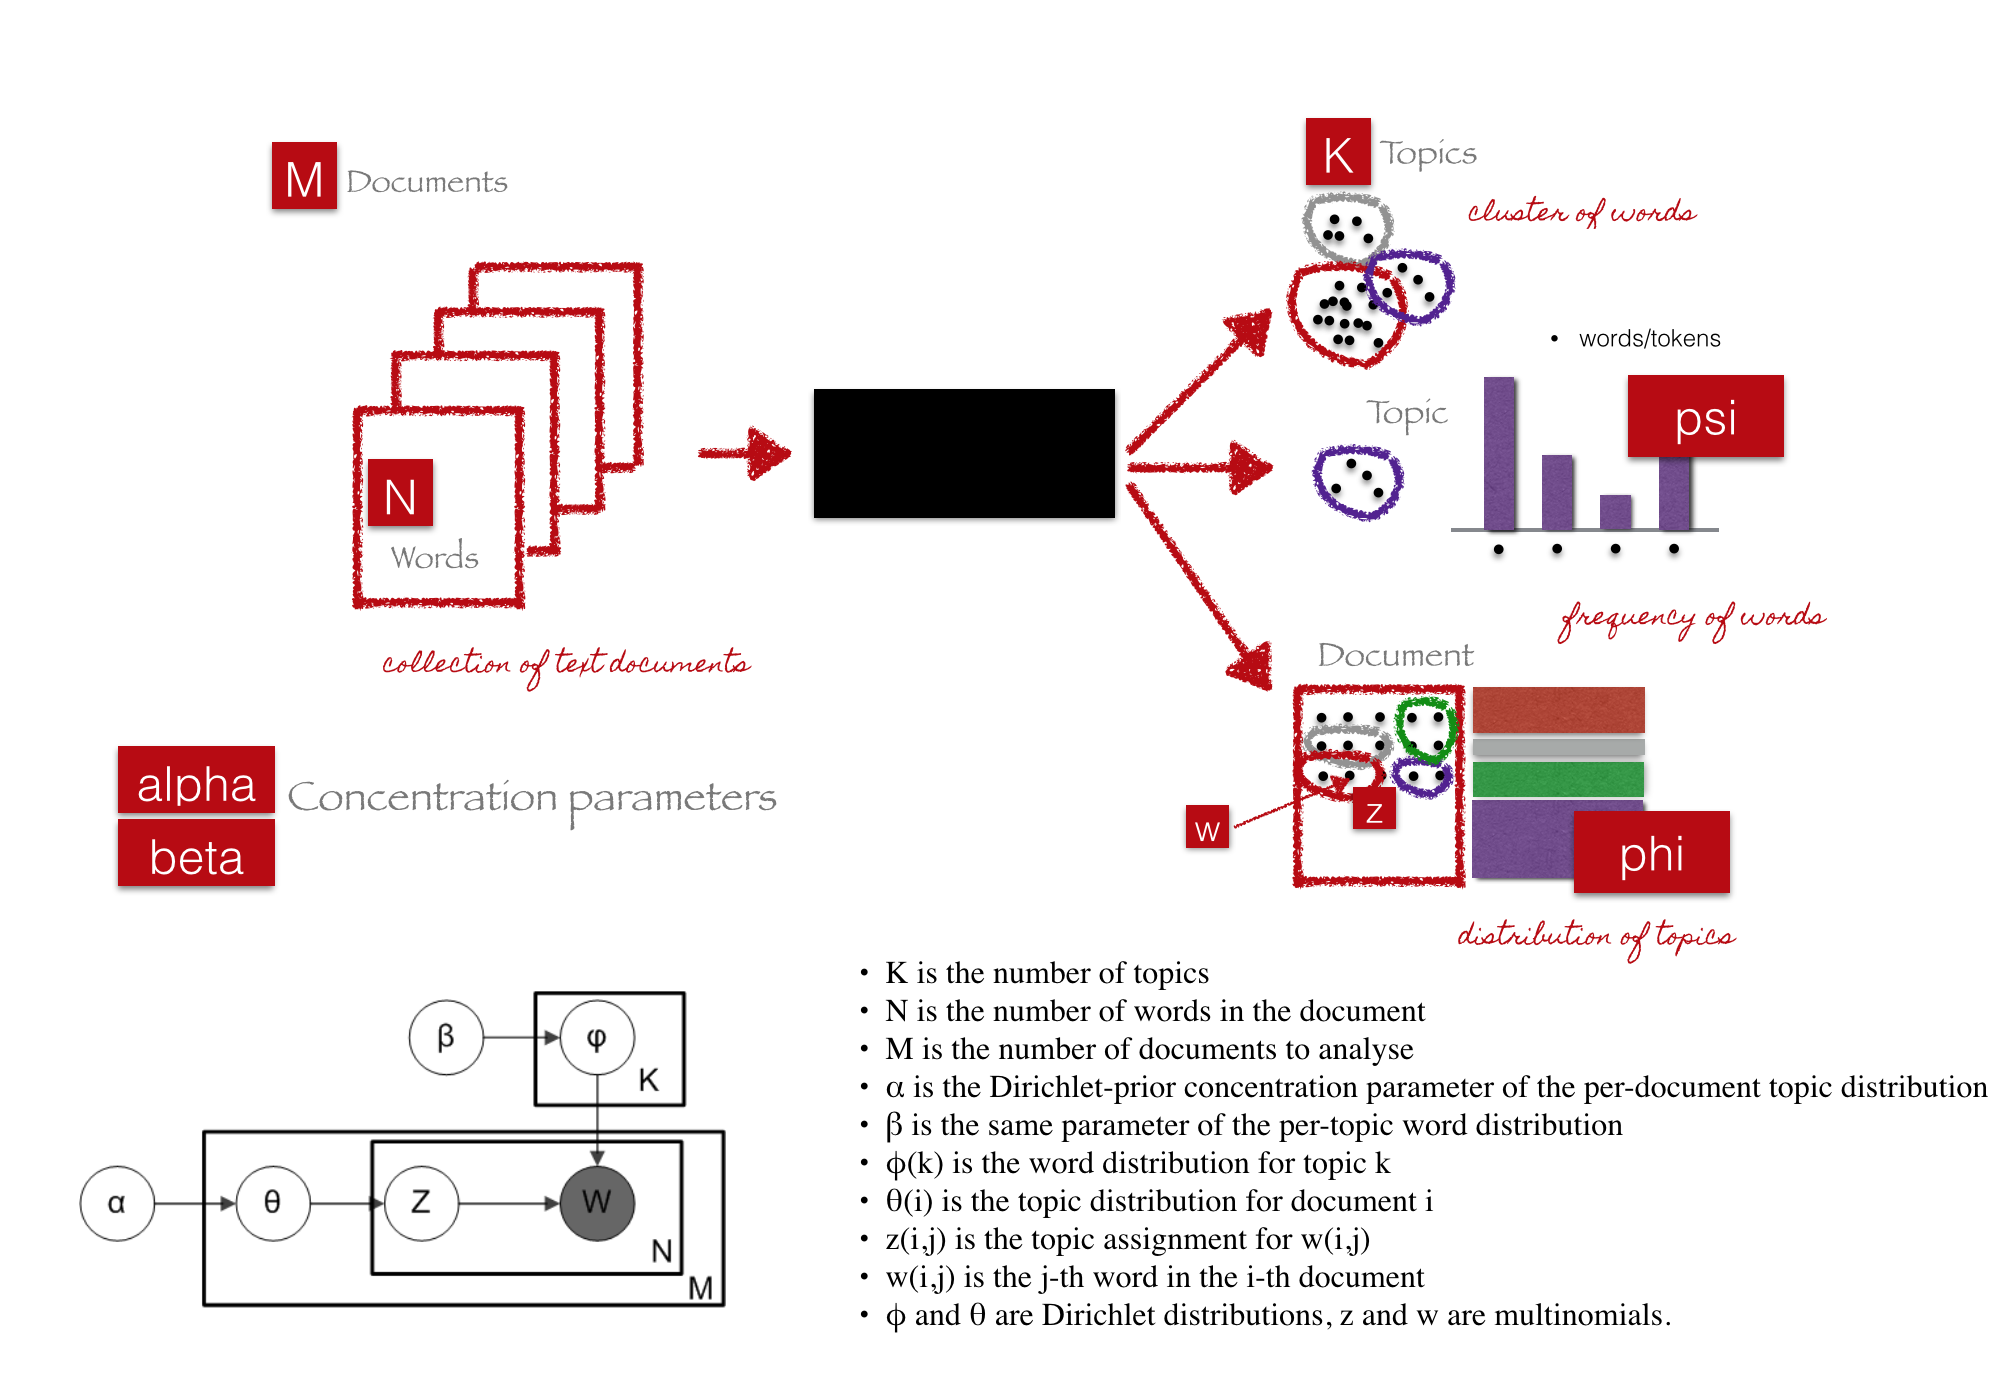

**Parameters of LDA**

* We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:
* psi, the distribution of words for each topic K
* phi, the distribution of topics for each document i
* Alpha parameter is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
* Beta parameter is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.






##### **Loading data**

For this tutorial, we’ll use the dataset of papers published in NIPS conference. The NIPS conference (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. The CSV data file contains information on the different NIPS papers that were published from 1987 until 2016 (29 years!). These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods, and many more.

In [67]:
# Importing modules
import pandas as pd
import os

#os.chdir('..')

# Read data into papers
#papers = pd.read_csv('./data/NIPS Papers/papers.csv')

papers = pd.read_csv(r"C:\Users\saurabhkumar9\NLP Practicum Materials\Data\papers.csv")

# Print head
papers.head(2)

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...


##### Data Cleaning

Since the goal of this analysis is to perform topic modeling, we will solely focus on the text data from each paper, and drop other metadata columns

In [68]:
# Remove the columns
papers = papers.drop(columns=['id', 'event_type', 'pdf_name'], axis=1)

# Print out the first rows of papers
papers.head(2)

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...


##### Remove punctuation/lower casing

Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [69]:
# Load the regular expression library
import re

# Remove punctuation
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
papers['paper_text_processed'].head()

<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
<ipython-input-69-854fdd4abaf9>:5: DeprecationWarning: invalid escape sequence \.
  papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    767\n\nself-organization of associative databa...
1    683\n\na mean field theory of layer iv of visu...
2    394\n\nstoring covariance by the associative\n...
3    bayesian query construction for neural\nnetwor...
4    neural network ensembles cross\nvalidation and...
Name: paper_text_processed, dtype: object

##### Exploratory Analysis

To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

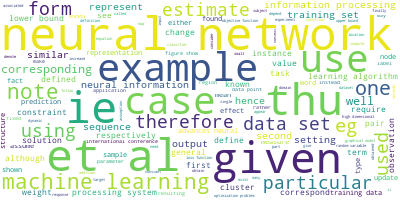

In [70]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

##### Prepare text for LDA analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by converting the documents into a simple vector representation (Bag of Words BOW). Next, we will convert a list of titles into lists of vectors, all with length equal to the vocabulary.

We’ll then plot the ten most frequent words based on the outcome of this operation (the list of document vectors). As a check, these words should also occur in the word cloud.

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(papers['paper_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)